Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import random # show random images
import glob # Problem 2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Note: Some code is taken from:
# https://github.com/rndbrtrnd/udacity-deep-learning/blob/master/1_notmnist.ipynb

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
# course-harcoded url
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    # Create path where the data file will be stored
    # get working directory and go to the parent - distro agnostic code
    dpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    # go to data directory
    dpath = os.path.join(dpath, 'data')
    # get filepath
    fpath = os.path.join(dpath, filename)
    if force or not os.path.exists(fpath):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    # move new file from working directory to data location
    # current file location
    cpath = os.path.join(os.getcwd(), filename)
    os.rename(cpath, fpath)
    return (filename)

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    # get new dir name
    dirn = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    # Create data directory path
    dpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    dpath = os.path.join(dpath, 'data')
    # Create dir to unzip data
    dirn = os.path.join(dpath, dirn)
    # Create zipped file path
    fpath = os.path.join(dpath, filename)
    if os.path.isdir(dirn) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (dirn, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % dirn)
        tar = tarfile.open(fpath)
        sys.stdout.flush()
        # set path so data are extracted within the data folder.
        tar.extractall(path=dpath)
        tar.close()
        
    data_folders = [
        os.path.join(dirn, d) for d in sorted(os.listdir(dirn))
        if os.path.isdir(os.path.join(dirn, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print("Data folders list:")
    print(data_folders)
    return(data_folders)
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for /home/nikolaos/ud370/data/notMNIST_large. This may take a while. Please wait.
Data folders list:
['/home/nikolaos/ud370/data/notMNIST_large/A', '/home/nikolaos/ud370/data/notMNIST_large/B', '/home/nikolaos/ud370/data/notMNIST_large/C', '/home/nikolaos/ud370/data/notMNIST_large/D', '/home/nikolaos/ud370/data/notMNIST_large/E', '/home/nikolaos/ud370/data/notMNIST_large/F', '/home/nikolaos/ud370/data/notMNIST_large/G', '/home/nikolaos/ud370/data/notMNIST_large/H', '/home/nikolaos/ud370/data/notMNIST_large/I', '/home/nikolaos/ud370/data/notMNIST_large/J']
Extracting data for /home/nikolaos/ud370/data/notMNIST_small. This may take a while. Please wait.
Data folders list:
['/home/nikolaos/ud370/data/notMNIST_small/A', '/home/nikolaos/ud370/data/notMNIST_small/B', '/home/nikolaos/ud370/data/notMNIST_small/C', '/home/nikolaos/ud370/data/notMNIST_small/D', '/home/nikolaos/ud370/data/notMNIST_small/E', '/home/nikolaos/ud370/data/notMNIST_small/F', '/home/nikolaos/ud370/data/n

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [6]:
def show_random_images(numi):
    """
    Function to display a specified number of random images from the extracted dataset.
    
    Arguments:
        numi: Integer, how many images to show.
    """
    # First let's create a list of all the files.
    # Create data directory path
    dpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    dpath = os.path.join(dpath, 'data')
    
    # notMNIST_small directory:
    dsmall = os.path.join(dpath, 'notMNIST_small')
    # notMNIST_large directory:
    dlarge = os.path.join(dpath, 'notMNIST_large')

    # create $numi random number of paths of images
    name1 = []
    it1 = 0
    while it1 < numi:
        # select random notMNIST
        rpath0 = random.choice([dlarge, dsmall])
        # select random letter
        rpath1 = random.choice(["A/", "B/", "C/", "D/", "E/", "F/", "H/", "I/", "J/"])
        # join them
        rpath = os.path.join(rpath0, rpath1)
        # select random image from files
        onlyfiles = [fi for fi in os.listdir(rpath) if os.path.isfile(os.path.join(rpath, fi))]
        name2 = random.choice(onlyfiles)
        # add that random name to it's path
        name2 = os.path.join(rpath, name2)
        # add it to list of images
        name1.append(name2)
        
        it1 += 1

    for it2 in name1:
        print("Showing Image from path:\n" +  it2)
        im1 = Image(filename=(it2))
        display(im1)
        
# show me 10 images
show_random_images(10)

Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_large/A/RHV2YWxsLnR0Zg==.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_small/C/Q2VudHVyeUlUQ2J5QlQtQm9sZENvbmRJdGFsaWMub3Rm.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_small/C/QmVydHJhbS50dGY=.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_small/B/R290aGljQmxvbmQtU2xpbS5vdGY=.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_small/C/RnV0dXJhIFQgRUUgTWVkaXVtIENvbmRlbnNlZC5wZmI=.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_large/C/R2xhc25vc3REZW1pYm9sZC5vdGY=.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_large/E/U3VwZXIgQm9iIFRyaWxpbmUgTmYudHRm.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_large/F/Q3lyaWxsaWMtTm9ybWFsLnR0Zg==.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_small/A/RmF0U2FtLnBmYg==.png


Showing Image from path:
/home/nikolaos/ud370/data/notMNIST_small/D/RHluYW1vUnhlSXRhbGljSFhFLm90Zg==.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
### Image preprocessing happening in this step !!! ###
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            # read image as array:
            # https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.ndimage.imread.html
            # code below also shifts average to 0 and standard deviation to 1
            # This scaling happens assuming the 255 pixel depth is uniformly populated.
            image_data = (ndimage.imread(image_file).astype(float) - 
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return(dataset)
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return(dataset_names)

train_datasets = maybe_pickle(train_folders, 50000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling /home/nikolaos/ud370/data/notMNIST_large/A.pickle.
/home/nikolaos/ud370/data/notMNIST_large/A
Could not read: /home/nikolaos/ud370/data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '/home/nikolaos/ud370/data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: /home/nikolaos/ud370/data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '/home/nikolaos/ud370/data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: /home/nikolaos/ud370/data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '/home/nikolaos/ud370/data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.44312
Pickling /home/nikolaos/ud370/data/notMNIST_large/B.pickle.
/home/nikolaos/ud370/data/notMNIST_large/B
Could not read: /home/nikolaos/ud370/d

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

/home/nikolaos/ud370/data/notMNIST_small/B.pickle


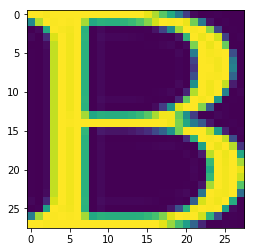

In [10]:
## Open a random image from the pickled files.

def show_rnd_pkl_image():
    """Function that shows a random pickled image."""
    # First let's create a list of all the files.
    # Create data directory path
    dpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    dpath = os.path.join(dpath, 'data')

    # notMNIST_small directory:
    dsmall = os.path.join(dpath, 'notMNIST_small')
    # notMNIST_large directory:
    dlarge = os.path.join(dpath, 'notMNIST_large')

    # Find all pickle files in each directory.
    # http://stackoverflow.com/a/3215392
    # Create a list of all nonMNIST_small pickles
    lsmall = glob.glob(dsmall + '/*.pickle')
    # Create a list of all nonMNIST_large pickles
    llarge = glob.glob(dlarge + '/*.pickle')

    # Pick a random pickle to load (either large or small !)
    rpklfile = random.choice([lsmall, llarge])
    rpklfile = random.choice(rpklfile)

    # verify randomness
    print(rpklfile)

    with open(rpklfile, 'rb') as rf:
        imgPkl = pickle.load(rf)

    plt.imshow(random.choice(list(imgPkl)))
    
show_rnd_pkl_image()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [11]:
def disp_number_images(data_folders):
    for folder in data_folders:
        pickle_filename = folder + '.pickle'
        try:
            with open(pickle_filename, 'rb') as f:
                dataset = pickle.load(f)
        except Exception as e:
            print('Unable to read data from', pickle_filename, ':', e)
            return
        print('Number of images in ', folder, ' : ', len(dataset))
    
disp_number_images(train_folders)
disp_number_images(test_folders)


Number of images in  /home/nikolaos/ud370/data/notMNIST_large/A  :  52909
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/B  :  52911
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/C  :  52912
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/D  :  52911
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/E  :  52912
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/F  :  52912
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/G  :  52912
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/H  :  52912
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/I  :  52912
Number of images in  /home/nikolaos/ud370/data/notMNIST_large/J  :  52911
Number of images in  /home/nikolaos/ud370/data/notMNIST_small/A  :  1872
Number of images in  /home/nikolaos/ud370/data/notMNIST_small/B  :  1873
Number of images in  /home/nikolaos/ud370/data/notMNIST_small/C  :  1873
Number of images in  /home/nikolaos/ud370

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [12]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 500000
valid_size = 29000
test_size = 18000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (500000, 28, 28) (500000,)
Validation: (29000, 28, 28) (29000,)
Testing: (18000, 28, 28) (18000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [13]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return (shuffled_dataset, shuffled_labels)
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

---
To be sure that the data are still fine after the merger and the randomization, I will select one item and display the image alongside the label. Note: 0 = A, 1 = B, 2 = C, 3 = D, 4 = E, 5 = F, 6 = G, 7 = H, 8 = I, 9 = J.

---

In [14]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def disp_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 8)
  for i, item in enumerate(items):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(pretty_labels[labels[item]])
    plt.imshow(dataset[item])

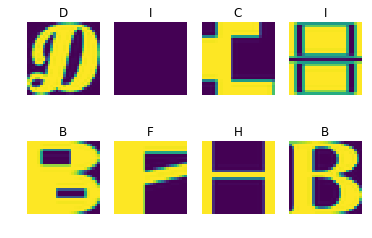

In [15]:
disp_sample_dataset(train_dataset, train_labels)

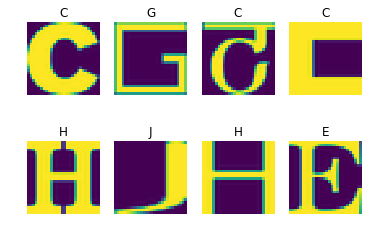

In [16]:
disp_sample_dataset(train_dataset, train_labels)

Finally, let's save the data for later reuse:

In [18]:
# Create data directory path
dpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
dpath = os.path.join(dpath, 'data')
# create pickle data file path
pickle_file = os.path.join(dpath,'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1717580521


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In this part, I will explore the datasets and understand better the overlap cases. There are overlaps, but there are also duplicates in the same dataset! Processing time is also critical. I will first use nested loops and matrix comparison, which is slow and then use hash function to accelerate and process the whole dataset.

In [20]:
def display_overlap(overlap, source_dataset, target_dataset):
    item = random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

def extract_overlap(dataset_1, dataset_2):
    overlap = {}
    for i, img_1 in enumerate(dataset_1):
        for j, img_2 in enumerate(dataset_2):     
            if np.array_equal(img_1, img_2):
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap



In [21]:
%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)

CPU times: user 6min 29s, sys: 0 ns, total: 6min 29s
Wall time: 6min 30s


Number of overlaps: 44


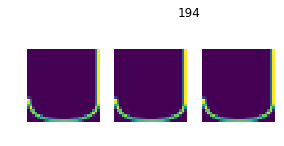

In [22]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 53.2 ms
Mean acccuracy of the linear regression model is: 0.5780555555555555


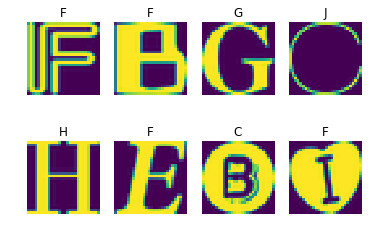

In [23]:
def tryLogRegr(sample_size):
    """
    
    Arguments:
        sample_size: Integer to determine sample size
    """
    
    regr = LogisticRegression()
    X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
    y_test = test_labels

    
    X_train = train_dataset[:sample_size].reshape(sample_size, 784)
    y_train = train_labels[:sample_size]
    %time regr.fit(X_train, y_train)
    rscore = regr.score(X_test, y_test)
    
    print("Mean acccuracy of the linear regression model is: {}"
          .format(rscore))
    
    pred_labels = regr.predict(X_test)
    disp_sample_dataset(test_dataset, pred_labels)

tryLogRegr(50)

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 119 ms
Mean acccuracy of the linear regression model is: 0.6584444444444445


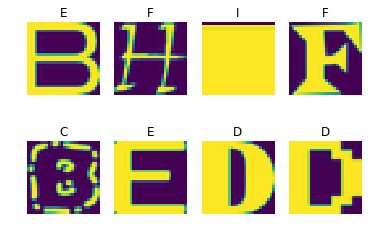

In [24]:
tryLogRegr(100)

CPU times: user 1.96 s, sys: 0 ns, total: 1.96 s
Wall time: 1.96 s
Mean acccuracy of the linear regression model is: 0.8401666666666666


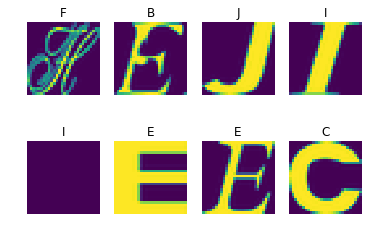

In [25]:
tryLogRegr(1000)

CPU times: user 17.8 s, sys: 0 ns, total: 17.8 s
Wall time: 17.9 s
Mean acccuracy of the linear regression model is: 0.8513333333333334


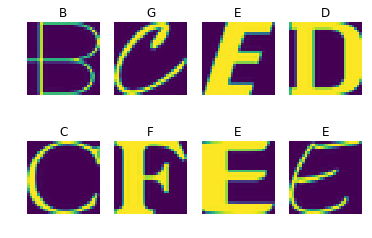

In [26]:
tryLogRegr(5000)

---
    
Looks like ~85% is the limit for a linear method
    
---

Let's try on all of the dataset.

CPU times: user 23min 59s, sys: 360 ms, total: 24min
Wall time: 7min 9s
Mean acccuracy of the linear regression model is: 0.8940555555555556


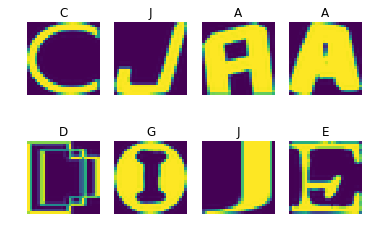

In [27]:
def tryLogRegrAll():
    """
    Function to perform Logistic Regression on all our dataset.
    """
    
    # sag solver works better for bigger datasets
    # n_jobs = -2 automatically selects (max - 1) available cores!
    # using -1
    regr = LogisticRegression(solver='sag', n_jobs = -1)
    X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
    y_test = test_labels
    
    X_train = train_dataset.reshape(train_dataset.shape[0], 784)
    y_train = train_labels
    %time regr.fit(X_train, y_train)
    rscore = regr.score(X_test, y_test)
    
    print("Mean acccuracy of the linear regression model is: {}"
          .format(rscore))
    
    pred_labels = regr.predict(X_test)
    disp_sample_dataset(test_dataset, pred_labels)

tryLogRegrAll()

# **Final Comments:**

 - Final Accuracy of 89% is quite impressive !
 - Multithreaded support out of the box is quite cool as well !